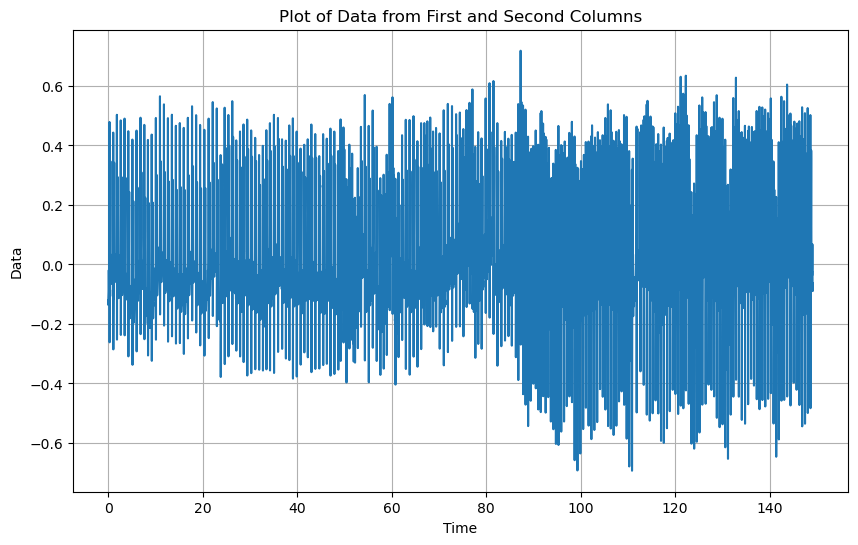

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with comma as delimiter
df = pd.read_csv("lab5_Philco-L05.txt", delimiter=",")

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[:, 0], df.iloc[:, 1])
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Plot of Data from First and Second Columns')
plt.grid(True)
plt.show()
